In [ ]:
import torch
import numpy as np
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from config import Config
from main import run
from data_utils import load_brown_words, reconstruct_sentences, replace_rare_words, clean_sentences, build_vocab, create_mapping, split_data, create_mlp_dataset, plot_training_results
from model import init_parameters, train_one_epoch
from evaluate import evaluate, sample_next_word_idx
from bengio2003.src.baseline import train_em, calculate_perplexity, get_counts

### 1) Define Hyperparameters

In [2]:

cfg = Config(
    device="cpu",
    model="mlp",
    emb_dim=30,
    hidden_dim=100,
    context_size=5,
    epochs=1, 
    batch_size=32, 
    epsilon_t=0.1,
    lr_decay=10**-8,
    weight_decay=10**-4,
    shuffle=True
    )
    
device = cfg.device
print(f"Using device: {device}")

g = torch.Generator().manual_seed(2147483647)

# run whole experiment based on config
# run(cfg)

Using device: cpu


### 2) Prepare Data

In [30]:
words = np.array(load_brown_words("./brown"))
print(f"Size of full dataset on word level: {words.shape[0]}")
sentences = reconstruct_sentences(words)
print(f"Size of full dataset on sentence level: {len(sentences)}")
print(f"Random sample of the data set: {words[:15]} \n")
train_sents, val_sents, test_sents = split_data(sentences, shuffle=cfg.shuffle)
train_sents_clean = replace_rare_words(train_sents, min_freq=3)

vocab, vocab_size = build_vocab(train_sents_clean)

print(f"Size of vocabulary: {vocab_size}")
val_sents_clean, test_sents_clean = clean_sentences(val_sents, vocab), clean_sentences(test_sents, vocab)
print(f"Size of train, val, test sets on sentence level: {len(train_sents_clean), len(val_sents_clean), len(test_sents_clean)}")

w2i, i2w = create_mapping(vocab)

Size of full dataset on word level: 1161192
Size of full dataset on sentence level: 55635
Random sample of the data set: ['The' 'Fulton' 'County' 'Grand' 'Jury' 'said' 'Friday' 'an'
 'investigation' 'of' "Atlanta's" 'recent' 'primary' 'election' 'produced'] 

Size of vocabulary: 19518
Size of train, val, test sets on sentence level: (44508, 5563, 5564)


In [29]:
train_words_flat = [word for sent in train_sents_clean for word in sent]
print(f"These are the top 10 most common words within the training data after cleaning: \n {Counter(train_words_flat).most_common(10)}")

These are the top 10 most common words within the training data after cleaning: 
 [('the', 50353), (',', 46977), ('.', 39503), ('<UNK>', 38599), ('of', 28923), ('and', 22544), ('to', 20525), ('a', 17547), ('in', 15695), ('that', 8232)]


### 3) Model Decision

#### a) MLP

In [31]:
# data prep for MLP
X_train, y_train = create_mlp_dataset(train_sents_clean, w2i)
X_val, y_val = create_mlp_dataset(val_sents_clean, w2i)
X_test, y_test = create_mlp_dataset(test_sents_clean, w2i)
print(f"Size of X_train, X_val, X_test using context size {cfg.context_size}: {X_train.shape, X_val.shape, X_test.shape}")

X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_val, y_val = torch.tensor(X_val), torch.tensor(y_val)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

Size of X_train, X_val, X_test using context size 5: ((976283, 5), (120039, 5), (120505, 5))


In [25]:
# init MLP
parameters = init_parameters(
    vocab_size,
    cfg.context_size, 
    cfg.emb_dim, 
    cfg.hidden_dim, 
    device, 
    g)

##### LR exploration

Text(0.5, 1.0, 'LR range testing')

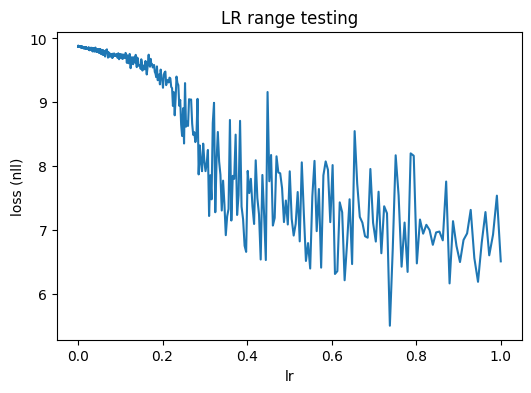

In [ ]:
lre = torch.linspace(-4, 0, 1000)
lrs = 10**lre

lri = []
lossi = []

C, W1, b1, W2, b2 = parameters


for k in range(1000):

    for batch in range(1):

        # batch selection
        start = torch.randint(0, X_train.shape[0], (cfg.batchs_size,), generator=g)
        X_batch, y_batch = X_train[start], y_train[start]
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        emb = C[X_batch]
        h = torch.tanh(emb.view(-1,cfg.context_size * cfg.emb_dim) @ W1 + b1)
        logits = (h @ W2 + b2) # + (emb.view(-1, context_size * embedding_dims) @ W_direct)

        # calculate loss (negative log likelihood)
        loss = F.cross_entropy(logits, y_batch)

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = lrs[k]
        with torch.no_grad():
            for p in parameters:
                p.data += -lr * p.grad

        # track stats
        lri.append(lr)
        lossi.append(loss.item())

plt.figure(figsize=(6,4))
plt.plot(lri, lossi)
plt.xlabel("lr")
plt.ylabel("loss (nll)")
plt.title("LR range testing")

entsprechend andere lr als im paper gewählt

In [ ]:
# training

# reset parameters
parameters = init_parameters(vocab_size, cfg.context_size, cfg.emb_dim, cfg.hidden_dim, device, g)

# 3.3 train
history = {
    'train_loss': [],
    'val_loss': [],
    'train_pp': [],
    'val_pp': [],
    'lr': []
}

t = 0
r = cfg.lr_decay * cfg.batch_size
epsilon_0 = cfg.epsilon_t

for epoch in range(cfg.epochs):
    
    # train for one epoch (that is len(X_train)/batch_size many steps)
    parameters, epoch_losses, epoch_lr = train_one_epoch(
        X_train, y_train, parameters,
        cfg.batch_size, cfg.context_size, cfg.emb_dim,
        epsilon_0, cfg.weight_decay, r, g, t, device)

    # compute and track train loss and perplexity
    avg_train_loss = np.mean(epoch_losses)
    history['train_loss'].append(avg_train_loss)
    history['train_pp'].append(np.exp(avg_train_loss))
    history['lr'].append(np.mean(epoch_lr))

    # compute and track val loss and perplexity
    avg_val_loss, val_pp = evaluate(X_val, y_val, device, cfg.context_size, cfg.emb_dim, parameters)
    history['val_loss'].append(avg_val_loss)
    history['val_pp'].append(val_pp)

    # print progress
    print(f"Epoch {epoch}: Train Loss {avg_train_loss:.4f} | Train PP {np.exp(avg_train_loss)} | Val Loss {avg_val_loss:.4f} | Val PP {val_pp:.2f}")
    print("==========================")

# report final test loss
avg_loss, perplexity = evaluate(X_test, y_test, device, cfg.context_size, cfg.emb_dim, parameters)
print(f"Final test loss: {avg_loss} | Final test perplexity: {perplexity}")

In [ ]:
# plot training (non randomized)
plot_training_results(history)

In [ ]:
# sampling
ix = torch.randint(0, X_val.shape[0], (1,)).item()
context = X_val[ix].tolist()
context = [w2i['<s>']] * 5
print(f"Start sequence is: {[i2w[i] for i in context]}")

generated_text = sample_next_word_idx(context, parameters, cfg.context_size, cfg.emb_dim, i2w)
print(" ".join(generated_text))

In [ ]:
# run training (normalized)
cfg = Config(
    device="cpu",
    model="mlp",
    emb_dim=30,
    hidden_dim=100,
    context_size=5,
    epochs=1, 
    batch_size=32, 
    epsilon_t=0.1,
    lr_decay=10**-8,
    weight_decay=10**-4,
    shuffle=False           # False!
    )
    
device = cfg.device
print(f"Using device: {device}")

g = torch.Generator().manual_seed(2147483647)

# run whole experiment based on config
run(cfg)

In [ ]:
# plot resuls of the randomized approach
plot_training_results(history)

#### b) Baseline (Trigram)

In [ ]:
# run training (normalized))
cfg = Config(
    device="cpu",
    model="baseline",
    emb_dim=30,
    hidden_dim=100,
    context_size=5,
    epochs=1, 
    batch_size=32, 
    epsilon_t=0.1,
    lr_decay=10**-8,
    weight_decay=10**-4,
    shuffle=True
    )
    
device = cfg.device
print(f"Using device: {device}")

g = torch.Generator().manual_seed(2147483647)

# run whole experiment based on config
run(cfg)

Using device: cpu
Starting ...
Using device: cpu
Size of full dataset on word level: 1161192
Size of full dataset on sentence level: 55635
Size of vocabulary: 19518
Size of train, val, test sets on sentence level: (44508, 5563, 5564)
The final train perplexity of the interpolated trigram model is: 29.831675789260558
The final test perplexity of the interpolated trigram model is: 210.82901679825807
The final validation perplexity of the interpolated trigram model is: 211.15502652248858


In [ ]:
# run training (non-normalized))
cfg = Config(
    device="cpu",
    model="baseline",
    emb_dim=30,
    hidden_dim=100,
    context_size=5,
    epochs=1, 
    batch_size=32, 
    epsilon_t=0.1,
    lr_decay=10**-8,
    weight_decay=10**-4,
    shuffle=False           # False!
    )
    
device = cfg.device
print(f"Using device: {device}")

g = torch.Generator().manual_seed(2147483647)

# run whole experiment based on config
run(cfg)

Using device: cpu
Starting ...
Using device: cpu
Size of full dataset on word level: 1161192
Size of full dataset on sentence level: 55635
Size of vocabulary: 20404
Size of train, val, test sets on sentence level: (44508, 5563, 5564)
The final train perplexity of the interpolated trigram model is: 33.540318292056774
The final test perplexity of the interpolated trigram model is: 168.78439593140965
The final validation perplexity of the interpolated trigram model is: 173.486714607302
